### Plot time series

In [19]:
# mom6_tools
from mom6_tools.DiagsCase import DiagsCase
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.m6toolbox import genBasinMasks
from mom6_tools.m6plot import myStats, annotateStats

import xarray as xr
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display
import warnings, os, yaml
warnings.filterwarnings("ignore")

In [20]:
diag_config_yml = yaml.load(open('diag_config_comparison.yml','r'),
                            Loader=yaml.Loader)

In [21]:
# initialize lists
dcase = []; casename=[]
label = []; outdir=[]
ncfiles=[]
ncases = len(diag_config_yml.keys()) - 1
if ncases < 2:
  # Create the case instance
  dcase = DiagsCase(diag_config_yml['Case'], xrformat=True)
  casename.append(dcase.casename)
  label.append(diag_config_yml['Case']['SNAME'])
  ncfiles.append(diag_config_yml['Case']['OCN_DIAG_ROOT'])
  DOUT_S = dcase.get_value('DOUT_S')
  if DOUT_S:
    outdir.append(dcase.get_value('DOUT_S_ROOT')+'/ocn/hist/')
  else:
    outdir.append(dcase.get_value('RUNDIR'))
else:
  for i in range(ncases):
    cname = 'Case{}'.format(i+1)
    dcase = DiagsCase(diag_config_yml[cname], xrformat=True)
    casename.append(dcase.casename)
    label.append(diag_config_yml[cname]['SNAME'])
    ncfiles.append(diag_config_yml[cname]['OCN_DIAG_ROOT'])
    DOUT_S = dcase.get_value('DOUT_S')
    if DOUT_S:
      outdir.append(dcase.get_value('DOUT_S_ROOT')+'/ocn/hist/')
    else:
      outdir.append(dcase.get_value('RUNDIR'))
    
# set avg dates
avg = diag_config_yml['Avg']
start_date = avg['start_date']
end_date = avg['end_date']

In [22]:
# for plotting, the following was a feedback from Keith Lindsay.
linestyle = ['solid','solid','solid',
             'dashed','dashed','dashed',
             'dotted','dotted','dotted']
color = ['black','tab:red','blue','black',
         'red','blue','black',
         'red','blue']

In [23]:
ncfiles

['/glade/u/home/gmarques/Notebooks/CESM_MOM6/B/b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice5.026c/ncfiles/',
 '/glade/u/home/gmarques/Notebooks/CESM_MOM6/B/b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice6.026e/ncfiles/',
 '/glade/u/home/gmarques/Notebooks/CESM_MOM6/B/b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice5.026f/ncfiles/',
 '/glade/u/home/gmarques/Notebooks/CESM_MOM6/B/b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice5.026g/ncfiles/']

### Global Mean T & S

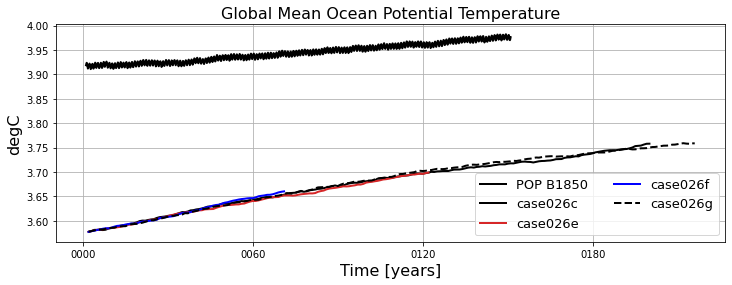

In [24]:
%matplotlib inline

path = '/glade/u/home/gmarques/Notebooks/POP/b.e21.B1850.f09_g17.CMIP6-piControl.001_time_series.nc'
temp = xr.open_dataset(path).TEMP.sel(time=slice(start_date,end_date))

fig = plt.figure(figsize=(12, 4))

plt.plot(temp.time, temp, label='POP B1850', color='k', lw=2)

for n in range(len(casename)):
  ds1 = xr.open_dataset(ncfiles[n]+casename[n]+'_mon_ave_global_means.nc')
  ds = ds1.sel(time=slice(start_date,end_date)).resample(time="1Y", closed='left').mean('time')
  plt.plot(ds.time, ds.thetaoga, label=label[n], lw=2, linestyle=linestyle[n],  
           color=color[n])

plt.title(ds1.thetaoga.long_name, fontsize=16)
plt.xlabel('Time [years]', fontsize=16)
plt.ylabel(ds1.thetaoga.units, fontsize=16)
plt.grid()
plt.legend(fontsize=13, ncol=2);

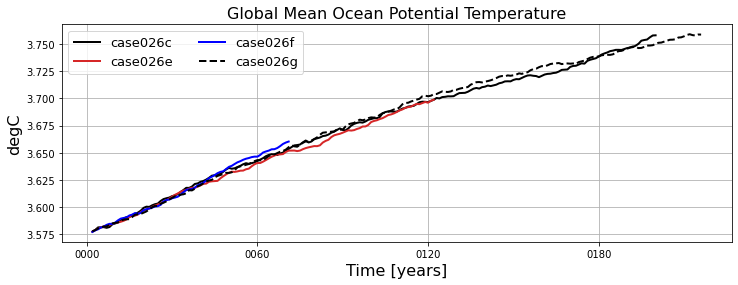

In [25]:
fig = plt.figure(figsize=(12, 4))

for n in range(len(casename)):
  ds1 = xr.open_dataset(ncfiles[n]+casename[n]+'_mon_ave_global_means.nc')
  ds = ds1.sel(time=slice(start_date,end_date)).resample(time="1Y", closed='left').mean('time')
  plt.plot(ds.time, ds.thetaoga, label=label[n], lw=2, linestyle=linestyle[n],  
           color=color[n])

plt.title(ds1.thetaoga.long_name, fontsize=16)
plt.xlabel('Time [years]', fontsize=16)
plt.ylabel(ds1.thetaoga.units, fontsize=16)
plt.grid()
plt.legend(fontsize=13, ncol=2);

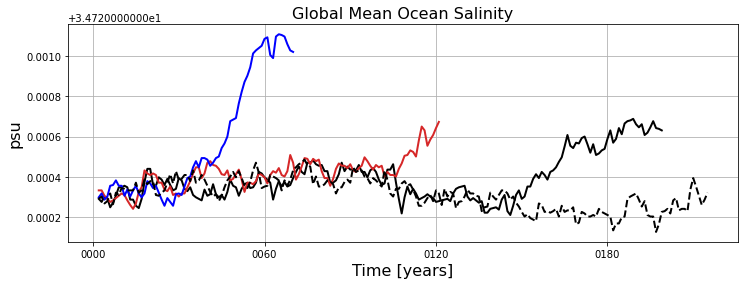

In [26]:
path = '/glade/u/home/gmarques/Notebooks/POP/b.e21.B1850.f09_g17.CMIP6-piControl.001_time_series.nc'
salt = xr.open_dataset(path).SALT.sel(time=slice(start_date,end_date))

fig = plt.figure(figsize=(12, 4))

#plt.plot(salt.time, salt, label='POP B1850', color='k', lw=2)

for n in range(len(casename)):
  ds1 = xr.open_dataset(ncfiles[n]+casename[n]+'_mon_ave_global_means.nc')
  ds = ds1.sel(time=slice(start_date,end_date)).resample(time="1Y", closed='left').mean('time')
  plt.plot(ds.time[0:-1], ds.soga[0:-1], label=label[n], lw=2, linestyle=linestyle[n],  
           color=color[n])

plt.title(ds1.soga.long_name, fontsize=16)
plt.xlabel('Time [years]', fontsize=16)
plt.ylabel(ds1.soga.units, fontsize=16)
plt.grid()

In [27]:
from ncar_jobqueue import NCARCluster
from dask.distributed import Client

cluster = NCARCluster()
cluster.scale(6)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/highmem/proxy/44812/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/highmem/proxy/44812/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.59:45011,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/highmem/proxy/44812/status,Total threads: 0
Started: Just now,Total memory: 0 B


### SST time series in the Lab Sea

In [28]:
# load grid and pre-difined masks
grd = MOM6grid(outdir[0]+'/'+casename[0]+'.mom6.static.nc');
grd_xr = MOM6grid(outdir[0]+'/'+casename[0]+'.mom6.static.nc', xrformat=True);
depth = grd.depth_ocean
# remote Nan's, otherwise genBasinMasks won't work
depth[np.isnan(depth)] = 0.0
basin_code = genBasinMasks(grd.geolon, grd.geolat, depth, xda=True);

MOM6 grid successfully loaded... 

MOM6 grid successfully loaded... 

11.16428 64.78855 [391, 434]


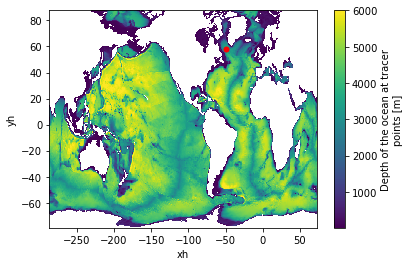

In [29]:
fig, ax = plt.subplots()
grd_xr.depth_ocean.plot(ax=ax)
dummy = grd_xr.depth_ocean.sel(xh = -50, yh = 58., method='nearest')
ax.plot(dummy.xh.values, dummy.yh.values, color='r', ms=5, marker='o');

In [30]:
def preprocess(ds):
    variables = ['tos','sos']
    return ds[variables]

b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice5.026c
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice6.026e
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice5.026f
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice5.026g


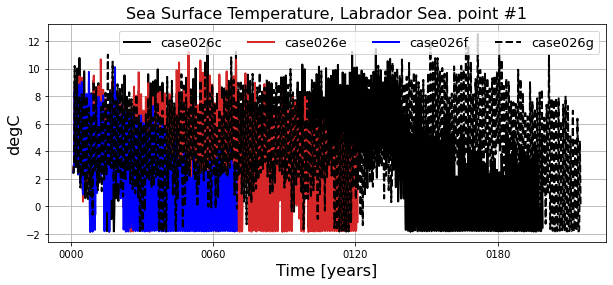

In [31]:
# load hm files
fig = plt.figure(figsize=(10, 4))

for n in range(len(casename)):
  print(casename[n])
  ds1 = xr.open_mfdataset(outdir[n]+'/'+casename[n]+'.mom6.hm_*.nc', 
                       parallel=True, preprocess=preprocess)
  ds = ds1.sel(time=slice(start_date,end_date))  
  var = ds.tos.sel(xh = -50, yh = 58., method='nearest')
  plt.plot(var.time, var, label=label[n], lw=2, linestyle=linestyle[n],  
           color=color[n])

plt.title(var.long_name + ', Labrador Sea. point #1', fontsize=16)
plt.xlabel('Time [years]', fontsize=16)
plt.ylabel(var.units, fontsize=16)
plt.grid()
plt.legend(fontsize=13, ncol=4);

b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice5.026c
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice6.026e
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice5.026f
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice5.026g


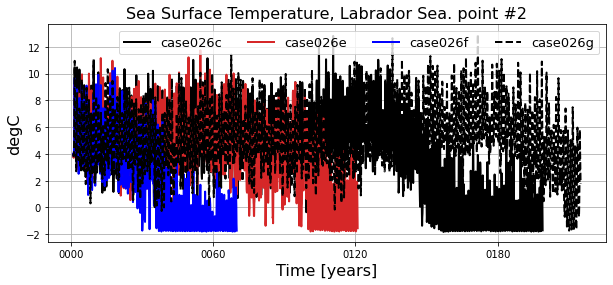

In [32]:
fig = plt.figure(figsize=(10, 4))

for n in range(len(casename)):
  print(casename[n])
  ds1 = xr.open_mfdataset(outdir[n]+'/'+casename[n]+'.mom6.hm_*.nc', 
                       parallel=True, preprocess=preprocess)
  ds = ds1.sel(time=slice(start_date,end_date))  
  var = ds.tos.sel(xh = -42, yh = 58.5, method='nearest')
  plt.plot(var.time, var, label=label[n], lw=2, linestyle=linestyle[n],  
           color=color[n])

plt.title(var.long_name + ', Labrador Sea. point #2', fontsize=16)
plt.xlabel('Time [years]', fontsize=16)
plt.ylabel(var.units, fontsize=16)
plt.grid()
plt.legend(fontsize=13, ncol=4);

#### Area weighted SST Lab Sea

In [33]:
lab_sea_mask = (basin_code.sel(region='LabSea').values* 1)
masked = np.ma.masked_where(lab_sea_mask==0, lab_sea_mask)
area_lab_sea = basin_code.sel(region='LabSea')*grd_xr.area_t

b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice5.026c
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice6.026e
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice5.026f
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice5.026g


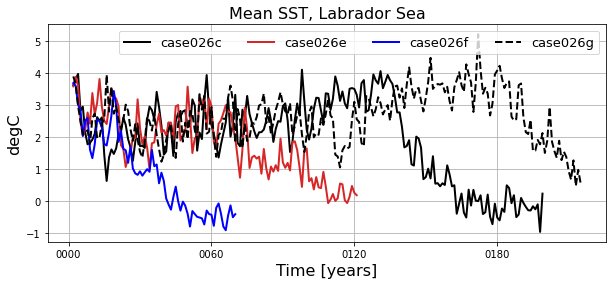

In [34]:
fig = plt.figure(figsize=(10, 4))

for n in range(len(casename)):
  print(casename[n])
  ds1 = xr.open_mfdataset(outdir[n]+'/'+casename[n]+'.mom6.hm_*.nc', 
                       parallel=True, preprocess=preprocess)
  ds = ds1.sel(time=slice(start_date,end_date))  
  var = (ds.tos*basin_code.sel(region='LabSea')).weighted(area_lab_sea).mean(("xh", "yh"))
  var = var.resample(time="1Y", closed='left').mean('time')
  plt.plot(var.time, var, label=label[n], lw=2, linestyle=linestyle[n],  
           color=color[n])

plt.title('Mean SST, Labrador Sea', fontsize=16)
plt.xlabel('Time [years]', fontsize=16)
plt.ylabel(ds.tos.units, fontsize=16)
plt.grid()
plt.legend(fontsize=13, ncol=4);

b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice5.026c
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice6.026e
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice5.026f
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice5.026g


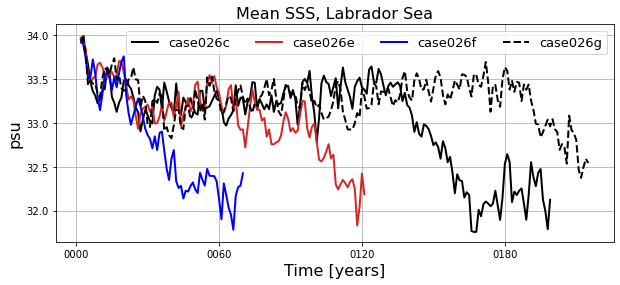

In [35]:
fig = plt.figure(figsize=(10, 4))

for n in range(len(casename)):
  print(casename[n])
  ds1 = xr.open_mfdataset(outdir[n]+'/'+casename[n]+'.mom6.hm_*.nc', 
                       parallel=True, preprocess=preprocess)
  ds = ds1.sel(time=slice(start_date,end_date))  
  var = (ds.sos*basin_code.sel(region='LabSea')).weighted(area_lab_sea).mean(("xh", "yh"))
  var = var.resample(time="1Y", closed='left').mean('time')
  plt.plot(var.time, var, label=label[n], lw=2, linestyle=linestyle[n],  
           color=color[n])

plt.title('Mean SSS, Labrador Sea', fontsize=16)
plt.xlabel('Time [years]', fontsize=16)
plt.ylabel(ds.sos.units, fontsize=16)
plt.grid()
plt.legend(fontsize=13, ncol=4);

### ACC Transport

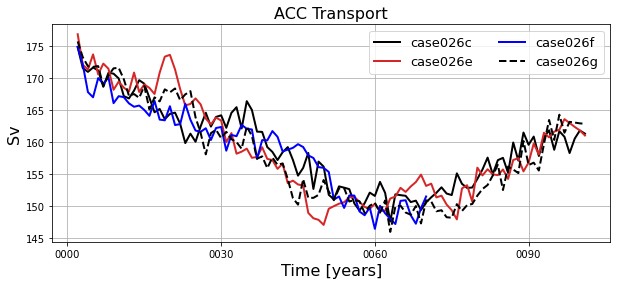

In [36]:
fig = plt.figure(figsize=(10, 4))

for n in range(len(casename)):
  ds = xr.open_dataset(ncfiles[n]+casename[n]+'_section_transports.nc').sel(time=slice(start_date,end_date))
  plt.plot(ds.time[0:-1], ds.sel(sections='Drake Passage').transport[0:-1], label=label[n], lw=2,
          linestyle=linestyle[n], color=color[n])

plt.title('ACC Transport', fontsize=16)
plt.xlabel('Time [years]', fontsize=16)
plt.ylabel('Sv', fontsize=16)
plt.grid()
plt.legend(fontsize=13, ncol=2);